# Previsão para playoff em Baseball

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import scipy
#from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from math import sqrt

# modelo
import statsmodels.formula.api as smf
# métricas
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report
# modelo de regressão logistica do sklearn
from sklearn.linear_model import LogisticRegression
# curva roc
from sklearn.metrics import roc_curve
# area embaixa do curva roc
from sklearn.metrics import roc_auc_score
# função para montar confusion matrix
from sklearn.metrics import confusion_matrix
# plotar confusion matrix
from sklearn.metrics import plot_confusion_matrix


Vamos usar o [dataset de baseball](https://raw.githubusercontent.com/abnr/ml-data/main/baseball.csv) para tentar prever quem vai para playoff da temporada. Esse dataset é composto pelas variáveis:

* Team: O código para o nome do time.
* League: A liga que o time pertence, pode ser AL ou NL
* Year: Ano do registro
* RS: o número de runs do time no ano.
* RA: O número de runs permitidos pelo time no ano.
* W: O número de vitórias na temporada 
* OBP: A porcentagem de 'on-base' 
* SLG: A slugging percentage do time no ano
* BA: A batting average do time no ano
* Playoffs: Se o time foi ou não para os playoffs
* RankSeason: Entre os times no playoff o rank final dele no ano.
* RankPlayoffs: O rank do time no playoff. O campeão tem rank 1.
* G: O número de partidas jogadas no ano.
* OOBP: A porcentagem de 'on-base' dos oponentes do ano.
* OSLG: A slugging percentage dos oponentes no ano.


In [4]:
df_base = pd.read_csv('https://raw.githubusercontent.com/abnr/ml-data/main/baseball.csv')
df_base.sort_values(by = 'Year', inplace= True)
#A partir de 1903, as duas ligas cooperaram uma com a outra, mas permaneceram entidades legalmente separadas até 2000, quando se fundiram em uma única organização liderada pelo Comissário do Beisebol.
#df_base = df_base.loc[df_base['League'] == 'NL']

In [5]:
df_base

,Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
1231,WSA,AL,1962,599,716,60,0.308,0.373,0.250,0,NaN,NaN,162,NaN,NaN
1212,BAL,AL,1962,652,680,77,0.314,0.387,0.248,0,NaN,NaN,162,NaN,NaN
1213,BOS,AL,1962,707,756,76,0.324,0.403,0.258,0,NaN,NaN,160,NaN,NaN
1214,CHC,NL,1962,632,827,59,0.317,0.377,0.253,0,NaN,NaN,162,NaN,NaN
1215,CHW,AL,1962,707,658,85,0.334,0.372,0.257,0,NaN,NaN,162,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,TEX,AL,2012,808,707,93,0.334,0.446,0.273,1,5.0,5.0,162,0.309,0.408
28,TOR,AL,2012,716,784,73,0.309,0.407,0.245,0,NaN,NaN,162,0.335,0.438
29,WSN,NL,2012,731,594,98,0.322,0.428,0.261,1,1.0,4.0,162,0.303,0.373
15,MIL,NL,2012,776,733,83,0.325,0.437,0.259,0,NaN,NaN,162,0.326,0.414


In [6]:
#Dummies de liga
df_base = pd.get_dummies(df_base, columns = ['League'], drop_first= True)


In [7]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1232 entries, 1231 to 0
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Team          1232 non-null   object 
 1   Year          1232 non-null   int64  
 2   RS            1232 non-null   int64  
 3   RA            1232 non-null   int64  
 4   W             1232 non-null   int64  
 5   OBP           1232 non-null   float64
 6   SLG           1232 non-null   float64
 7   BA            1232 non-null   float64
 8   Playoffs      1232 non-null   int64  
 9   RankSeason    244 non-null    float64
 10  RankPlayoffs  244 non-null    float64
 11  G             1232 non-null   int64  
 12  OOBP          420 non-null    float64
 13  OSLG          420 non-null    float64
 14  League_NL     1232 non-null   uint8  
dtypes: float64(7), int64(6), object(1), uint8(1)
memory usage: 145.6+ KB


In [8]:
#Normalizando a variável Winner em relação a Game
df_base['W_norm'] = df_base['W'] / df_base['G']
df_base.drop(['Team', 'W', 'G'], axis = 1, inplace = True)
df_base['W_norm'].describe()
# não é 1 porque pode ser q o campeão perdeu algum jogo nas primeiras fases

count    1232.000000
mean        0.499638
std         0.070607
min         0.248447
25%         0.450617
50%         0.500000
75%         0.549383
max         0.716049
Name: W_norm, dtype: float64

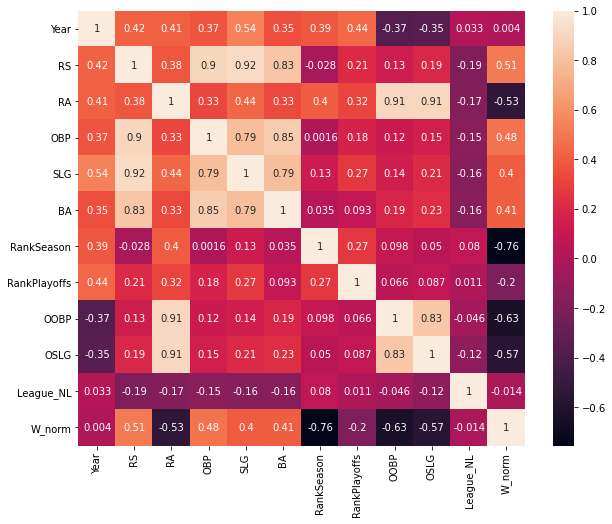

1962

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(df_base.drop(['Playoffs'], axis=1).corr(), annot=True)
plt.show()
df_base['Year'].min()

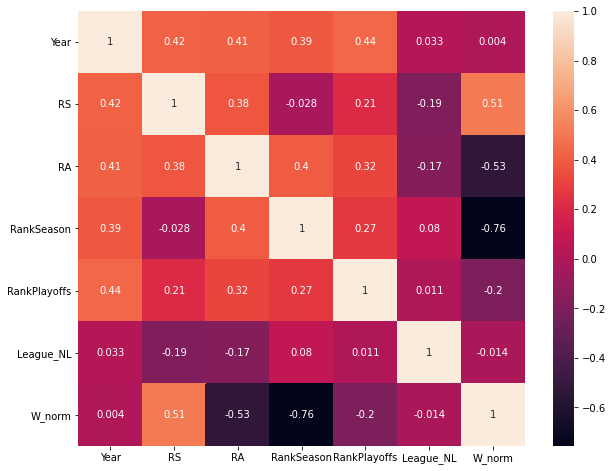

In [10]:
df_base.drop(['OSLG', 'OOBP', 'BA', 'SLG', 'OBP'], axis = 1, inplace = True) #tem alta correlação
plt.figure(figsize=(10,8))
sns.heatmap(df_base.drop(['Playoffs'], axis=1).corr(), annot=True)
plt.show()

In [11]:
df_base['RankSeason'].unique()

array([nan,  1.,  2.,  4.,  3.,  6.,  5.,  7.,  8.])

In [12]:
#preenchendo valores nulos
df_base['RankSeason'].fillna(9, inplace = True)

In [13]:
df_base['RankPlayoffs'].unique()

array([nan,  2.,  1.,  3.,  4.,  5.])

In [14]:
df_base['Playoffs'].unique()

array([0, 1], dtype=int64)

In [15]:
# 0 ou 1 ( 1 é campeão )
list = []
for item in df_base['RankPlayoffs']:
  if item != 1:
    list.append(0)
  else:
    list.append(1)
df_base['RankPlayoffs'] = list
df_base['RankPlayoffs'].unique()

array([0, 1], dtype=int64)

In [16]:
df_base.loc[df_base['RankPlayoffs'] == 1]
# não houve campeão em 1994 porque houve uma greve

,Year,RS,RA,Playoffs,RankSeason,RankPlayoffs,League_NL,W_norm
1226,1962,817,680,1,2.0,1,0,0.592593
1202,1963,640,550,1,2.0,1,1,0.607362
1190,1964,715,652,1,2.0,1,1,0.574074
1162,1965,608,521,1,2.0,1,1,0.598765
1133,1966,755,601,1,1.0,1,0,0.606250
1130,1967,695,557,1,1.0,1,1,0.627329
1100,1968,671,492,1,1.0,1,0,0.628049
1082,1969,632,541,1,2.0,1,1,0.617284
1045,1970,792,574,1,1.0,1,0,0.666667
1039,1971,788,599,1,2.0,1,1,0.598765


In [17]:
#Modelo de treino dados de 2000 a 2010
df_base_train = df_base.loc[df_base['Year'] >= 2000 ]
df_base_train = df_base_train.loc[df_base['Year'] <= 2010 ]


In [18]:
df_base_test = df_base.loc[df_base['Year'] > 2010]

In [19]:
df_base_train.info()
df_base_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 372 to 74
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          330 non-null    int64  
 1   RS            330 non-null    int64  
 2   RA            330 non-null    int64  
 3   Playoffs      330 non-null    int64  
 4   RankSeason    330 non-null    float64
 5   RankPlayoffs  330 non-null    int64  
 6   League_NL     330 non-null    uint8  
 7   W_norm        330 non-null    float64
dtypes: float64(2), int64(5), uint8(1)
memory usage: 20.9 KB


Year            0
RS              0
RA              0
Playoffs        0
RankSeason      0
RankPlayoffs    0
League_NL       0
W_norm          0
dtype: int64

In [20]:
df_base_train.describe()

,Year,RS,RA,Playoffs,RankSeason,RankPlayoffs,League_NL,W_norm
count,330.00000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000
mean,2005.00000,765.121212,765.121212,0.266667,7.557576,0.033333,0.533333,0.499894
std,3.16708,79.568577,83.453009,0.442888,2.584385,0.179778,0.499645,0.071613
min,2000.00000,513.000000,556.000000,0.000000,1.000000,0.000000,0.000000,0.265432
25%,2002.00000,712.250000,704.250000,0.000000,7.000000,0.000000,0.000000,0.444444
50%,2005.00000,760.000000,759.000000,0.000000,9.000000,0.000000,1.000000,0.506173
75%,2008.00000,813.750000,823.000000,1.000000,9.000000,0.000000,1.000000,0.555556
max,2010.00000,978.000000,974.000000,1.000000,9.000000,1.000000,1.000000,0.716049


In [21]:
df_base_test.describe()

,Year,RS,RA,Playoffs,RankSeason,RankPlayoffs,League_NL,W_norm
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,2011.500000,697.083333,697.083333,0.300000,7.483333,0.033333,0.533333,0.500001
std,0.504219,70.799620,76.912517,0.462125,2.521041,0.181020,0.503098,0.071472
min,2011.000000,556.000000,529.000000,0.000000,1.000000,0.000000,0.000000,0.339506
25%,2011.000000,644.750000,646.750000,0.000000,6.000000,0.000000,0.000000,0.444444
50%,2011.500000,705.500000,695.500000,0.000000,9.000000,0.000000,1.000000,0.500000
75%,2012.000000,734.250000,748.500000,1.000000,9.000000,0.000000,1.000000,0.557099
max,2012.000000,875.000000,890.000000,1.000000,9.000000,1.000000,1.000000,0.629630


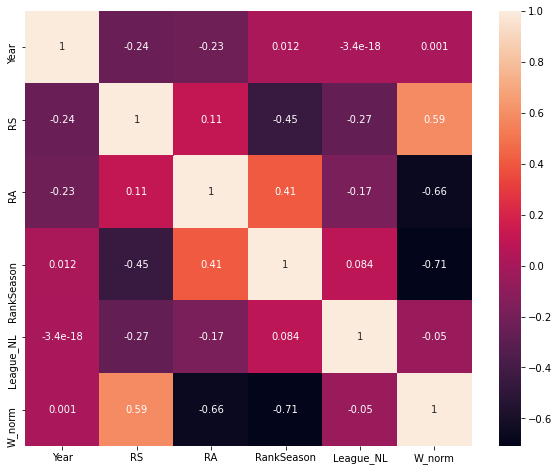

In [22]:
plt.figure(figsize=(10,8))
sns.heatmap(df_base_train.drop(['Playoffs', 'RankPlayoffs'], axis=1).corr(), annot=True)
plt.show()

In [24]:
# 1o Modelo: quem vai para Playoff 0 não vai 1 vai
# Regressão logística stats model

# function_formula = 'Playoffs ~ Year + RS + RA + RankSeason + RankPlayoffs  + League_NL + W_norm ' 
# tirei RankPlayoffs não faz sentido

# Retirada dos coeficientes não siginificativos
# 1 Pelo heatmap seria interessante tirar o W_norm ou RankSeason, então vi os vif para tirar a dúvida
# 2 tirei por Vifs : W_norm, Year, RA, não tinha mais vif pra tirar estavam todos < 10
# 3 o modelo não deu certo, nem rodou : Perfect separation detected, results not available
# 4 voltei para o começo (Retirada dos coeficientes não siginificativos) e não retirei W_norm, retirei o RankSeason pq o RankSeason os nans considerei 9 pq o rank ia de 1 a 8, depois disso não seguia a ordem até o final, dos 1232 só tinham 244 preenchidos
# 5 tirei por vifs: Year, RS.  W_norm e RA estavam mto próximos, então descartei o > : W_Norm . No final a maior precisão é 0,5 e acurácia 0,7, threshold 0,4
# 6 voltei par o item 5 e mantive o W-norm na etapa dos vifs e descartei o  RA e deu um melhor modelo, precisao 0,8 e acuracia 0,9 threshold 0,4 e o gráfico ficou melhor


#Modelo final dos playoffs

function_formula = ' Playoffs ~  League_NL + W_norm ' 
reg_log_b_train = smf.logit(formula=function_formula, data=df_base_train)
reg_log_b_train = reg_log_b_train.fit()


Optimization terminated successfully.
         Current function value: 0.176301
         Iterations 10


In [25]:
print(reg_log_b_train.summary())

                           Logit Regression Results                           
Dep. Variable:               Playoffs   No. Observations:                  330
Model:                          Logit   Df Residuals:                      327
Method:                           MLE   Df Model:                            2
Date:                Sat, 26 Jun 2021   Pseudo R-squ.:                  0.6960
Time:                        17:09:58   Log-Likelihood:                -58.179
converged:                       True   LL-Null:                       -191.37
Covariance Type:            nonrobust   LLR p-value:                 1.429e-58
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -49.7322      6.969     -7.137      0.000     -63.390     -36.074
League_NL      1.1091      0.516      2.150      0.032       0.098       2.120
W_norm        88.8932     12.433      7.150      0.0

In [26]:
vif_base_playoff = pd.DataFrame()
features_playoff = df_base_train.drop(['Playoffs', 'RankPlayoffs', 'RankSeason', 'Year', 'RS', 'RA'], axis = 1)
vif_base_playoff["features"] = features_playoff.columns
vif_base_playoff["VIF Factor"] = [variance_inflation_factor(features_playoff.values, i) for i in range(features_playoff.shape[1])]
vif_base_playoff.sort_values(by = 'VIF Factor', ascending= False)


,features,VIF Factor
0,League_NL,2.064597
1,W_norm,2.064597


In [27]:
Y_train_base = df_base_train['Playoffs']


In [28]:
X_train_base = df_base_train[['League_NL', 'W_norm']]
X_train_base

,League_NL,W_norm
372,1,0.444444
371,1,0.490683
370,0,0.487654
369,1,0.506173
368,0,0.555556
...,...,...
78,0,0.586420
77,1,0.487654
76,0,0.580247
82,1,0.555556


In [29]:
threshold = 0.5
Y_pred_train_base = reg_log_b_train.predict(X_train_base) >= threshold
Y_pred_train_base

372    False
371    False
370    False
369    False
368    False
       ...  
78      True
77     False
76      True
82      True
74     False
Length: 330, dtype: bool

In [30]:
#recall
recall_score(Y_train_base, Y_pred_train_base)

0.8409090909090909

In [31]:
#precision queremos alta acurácia e precisão
precision_score(Y_train_base, Y_pred_train_base)

0.8705882352941177

In [32]:
accuracy_score(Y_train_base, Y_pred_train_base)

0.9242424242424242

In [33]:
thresholds = np.arange(0, 1, 0.01)


In [34]:
Y_previsoes = reg_log_b_train.predict(X_train_base)

In [35]:
recall = []
precision = []

In [36]:
for i in thresholds:
    Y_predict_bool_aux = Y_previsoes >= i
    recall.append(recall_score(Y_train_base, Y_predict_bool_aux))
    precision.append(precision_score(Y_train_base, Y_predict_bool_aux))

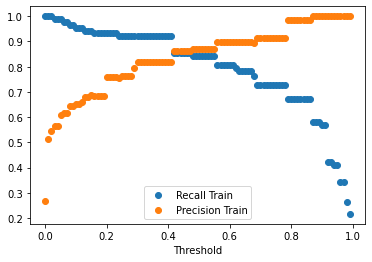

In [37]:
plt.scatter(thresholds, recall, label='Recall Train')
plt.scatter(thresholds, precision,label='Precision Train')
plt.xlabel('Threshold')
plt.legend()
plt.show()

In [54]:
#regressão no sklearn
reg_log_b_train_sk = LogisticRegression(fit_intercept=True, max_iter=200, class_weight='balanced')

reg_log_b_train_sk.fit(X_train_base, Y_train_base)
Y_pred_train_base_sk = reg_log_b_train_sk.predict(X_train_base)

In [55]:
prob_playoff = reg_log_b_train_sk.predict_proba(X_train_base)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(Y_train_base, prob_playoff, pos_label=1)

Text(0.5, 1.0, 'prob_playoff_model ROC Curve')

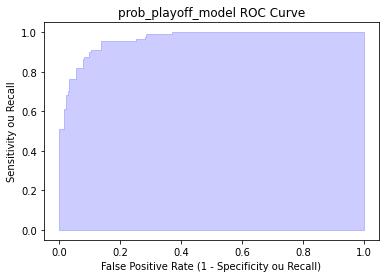

In [56]:
plt.fill_between(false_positive_rate_values, sensitivity_values, step='post', alpha=0.2,color='b')

plt.xlabel('False Positive Rate (1 - Specificity ou Recall)')
plt.ylabel('Sensitivity ou Recall')
plt.title('prob_playoff_model ROC Curve')

In [57]:
roc_auc_score(Y_train_base, prob_playoff)

0.9649934259954921

AUC é interpretada como a probabilidade do classificador atribuir uma probabilidade maior para dado escolhido aleatoriamente que pertence de verdade para a classe positiva que um dado escolhido aleatoriamente da classe negativa. O valor 0.96 significa que 95,9% das vezes é mais provável do modelo classificar um time que vai para o playoff ir para o playoff do que um time que não vai para playoff ir para o playoff

In [58]:
#matriz de confusão do treino(modelo)

In [59]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

#words_list_model_y_pred = words_list_model.predict(X_train)
Y_pred_train_base_sk

from sklearn.metrics import confusion_matrix

class_names = ['Playoff', 'Not Playoff']

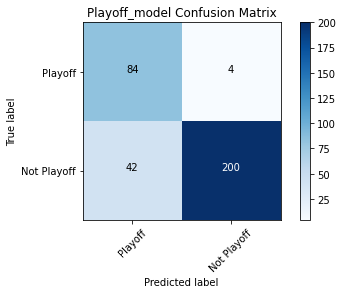

In [60]:
#matriz de confusão treino(modelo)

matriz_conf_train = confusion_matrix(Y_train_base, Y_pred_train_base_sk,  labels=[1, 0])
plot_confusion_matrix(matriz_conf_train, classes=class_names,
                      title='Playoff_model Confusion Matrix')
#interpretação predicted label diz se é N ou P. O true label diz se é F(sinais !=s) ou T (sinais =s)
#TP = 84, FN = 4 FP = 42  TN = 200
# recall =  TP /(TP+FN), precision = TP /(TP+FP)


In [61]:
matriz_conf_train #idem acima
#returns : Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class

array([[ 84,   4],
       [ 42, 200]], dtype=int64)

In [62]:
print(recall_score(Y_train_base, Y_pred_train_base_sk))
# recall =  TP /(TP+FN)
matriz_conf_train[0,0]/(matriz_conf_train[0,0] + matriz_conf_train[0,1])

0.9545454545454546


0.9545454545454546

In [63]:
print(precision_score(Y_train_base, Y_pred_train_base_sk))
#precision = TP /(TP+FP)
matriz_conf_train[0,0]/(matriz_conf_train[0,0] + matriz_conf_train[1,0])

0.6666666666666666


0.6666666666666666

In [64]:
print(accuracy_score(Y_train_base, Y_pred_train_base_sk))


0.8606060606060606


In [65]:
#Preparo dos dados do teste

X_test_base = df_base_test[['League_NL', 'W_norm']]
Y_pred_test_base_sk = reg_log_b_train_sk.predict(X_test_base)
Y_test_base = df_base_test['Playoffs']

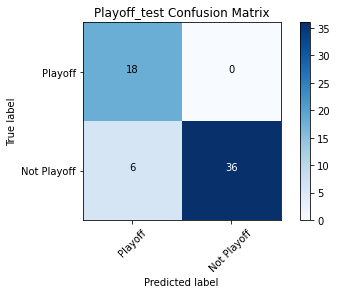

In [66]:
#matriz de confusão do teste

matriz_conf_test = confusion_matrix(Y_test_base, Y_pred_test_base_sk,  labels=[1, 0])
plot_confusion_matrix(matriz_conf_test, classes=class_names,
                      title='Playoff_test Confusion Matrix')

In [68]:
matriz_conf_test = confusion_matrix(Y_test_base, Y_pred_test_base_sk,  labels=[1, 0])
matriz_conf_test

array([[18,  0],
       [ 6, 36]], dtype=int64)

In [69]:
print(recall_score(Y_test_base, Y_pred_test_base_sk))
# recall =  TP /(TP+FN)
matriz_conf_test[0,0]/(matriz_conf_test[0,0] + matriz_conf_test[0,1])

1.0


1.0

In [70]:
#Especificidade 
matriz_conf_test[1,1]/(matriz_conf_test[1,1] + matriz_conf_test[1,0])

0.8571428571428571

In [71]:
print(precision_score(Y_test_base, Y_pred_test_base_sk))
#precision = TP /(TP+FP)
matriz_conf_test[0,0]/(matriz_conf_test[0,0] + matriz_conf_test[1,0])

0.75


0.75

In [72]:
print(accuracy_score(Y_test_base, Y_pred_test_base_sk))
#accuracy = TP+ TN /(TP+FP + TN + FN)
(matriz_conf_test[0,0] + matriz_conf_test[1,1]) /(matriz_conf_test[0,0] + matriz_conf_test[0,1] + matriz_conf_test[1,0] + matriz_conf_test[1,1])

0.9


0.9